In [2]:
import os
import sys
import random
import json
import time
import numpy as np
import torch
import torchvision
from tqdm import tqdm
from datetime import datetime
from functools import partial
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from svetlanna.units import ureg
import svetlanna as sv
from src.wf_datasets import DatasetOfWavefronts
from src.clf_loops import onn_train_clf, onn_validate_clf

In [3]:
plt.style.use('dark_background')
%matplotlib inline

In [4]:
# Constants

DIR_RESULTS = 'results'
MNIST_DATA_FOLDER = './data'  # folder to store data
MAX_PHASE = 2 * np.pi # TODO: Try to remove it
FREESPACE_METHOD = 'AS'  # we use an angular spectrum method
MODULATION_TYPE = 'amp' # We will not touch initial phase
NUMBER_OF_CLASSES = 10
ZONES_HIGHLIGHT_COLOR = 'w'
ZONES_LW = 0.5
DEVICE = 'cpu'
RESULTS_FOLDER = f'{DIR_RESULTS}/exp_20-06-2025_14-48'

In [5]:
print(*os.listdir(DIR_RESULTS), sep='\n')
print(f"\n{RESULTS_FOLDER=}")

exp_24-06-2025_13-30
exp_zones_23-06-2025_23-03
exp_radial_25-06-2025_01-44
exp_radial_25-06-2025_06-17
exp_triplets_24-06-2025_13-51
exp_radial_25-06-2025_02-27
exp_radial_24-06-2025_22-51
exp_zones_23-06-2025_19-08
exp_zones_24-06-2025_00-52
exp_radial_24-06-2025_21-52
exp_radial_25-06-2025_08-00
exp_zones_23-06-2025_22-03
test_acc_01-layers.json
test_acc_05-layers.json
exp_zones_23-06-2025_21-05
exp_radial_25-06-2025_07-01
exp_zones_24-06-2025_00-18
exp_radial_26-06-2025_10-36
exp_20-06-2025_15-09
exp_radial_25-06-2025_00-04
exp_stripes_25-06-2025_00-10
exp_23-06-2025_13-46
exp_stripes_24-06-2025_20-41
exp_zones_23-06-2025_22-39
exp_22-06-2025_00-04
.ipynb_checkpoints
test_acc_03-layers.json
exp_21-06-2025_21-27
exp_triplets_24-06-2025_22-07
exp_stripes_24-06-2025_18-26
exp_22-06-2025_15-07
exp_triplets_25-06-2025_00-24
exp_zones_23-06-2025_18-23
exp_23-06-2025_12-42
exp_22-06-2025_18-12
exp_zones_24-06-2025_00-25
exp_stripes_24-06-2025_22-02
exp_radial_25-06-2025_04-36
exp_23-06-20

In [6]:
# Variable

print(variables := json.load(open(f'{RESULTS_FOLDER}/conditions.json')))
globals().update(variables)
detector_size = aperture_size if use_apertures else mesh_size
print("Layer size x, m:", x_layer_size := mesh_size[1] * neuron_size)
print("Layer size y, m:", y_layer_size := mesh_size[0] * neuron_size)

sim_params = sv.SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size / 2, x_layer_size / 2, mesh_size[1]),
        'H': torch.linspace(-y_layer_size / 2, y_layer_size / 2, mesh_size[0]),
        'wavelength': wavelength,
    }
)
init_phases = torch.ones(num_diff_layers) * np.pi # Todo: try zeros in an attempt to remove that at all
# Or something more random as why not?
test_batch_size = 10
detector_segment_size_m = detector_segment_size * neuron_size # in [m]
detector_mask = torch.load(f'{RESULTS_FOLDER}/detector_mask.pt')
detector_processor = sv.detector.DetectorProcessorClf( # TODO: What does Clf mean
    simulation_parameters=sim_params,
    num_classes=NUMBER_OF_CLASSES,
    segmented_detector=detector_mask,
)
selected_detector_mask = detector_processor.segmented_detector.clone().detach() # ???
loss_func_clf = torch.nn.CrossEntropyLoss()
loss_func_name = 'CE loss'
losses_data = np.genfromtxt(f'{RESULTS_FOLDER}/training_curves.csv', delimiter=',')

{'wavelength': 0.000749481145, 'neuron_size': 0.00039722500685, 'mesh_size': [200, 200], 'use_apertures': False, 'aperture_size': [200, 200], 'detector_segment_size': 12, 'segments_order': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'train_val_seed': 47, 'torch_seed': 73, 'num_diff_layers': 3, 'free_space_distance': 0.029979245800000002, 'train_batch_size': 20, 'val_batch_size': 8, 'adam_lr': 0.001, 'number_of_epochs': 3}
Layer size x, m: 0.07944500137
Layer size y, m: 0.07944500137


In [7]:
mnist = partial(torchvision.datasets.MNIST, root=MNIST_DATA_FOLDER, download=True)
mnist_train_ds = mnist(train=True)
mnist_test_ds = mnist(train=False)

In [8]:
resize_y = int(detector_size[0] / 2)
resize_x = int(detector_size[1] / 2)  # shape for transforms.Resize

# paddings along OY
pad_top = int((mesh_size[1] - resize_y) / 2)
pad_bottom = mesh_size[0] - pad_top - resize_y
# paddings along OX
pad_left = int((mesh_size[0] - resize_x) / 2)
pad_right = mesh_size[1] - pad_left - resize_x  # params for transforms.Pad

In [9]:
# compose all transforms!
from svetlanna.transforms import ToWavefront
image_transform_for_ds = torchvision.transforms.Compose(
  [
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=torchvision.transforms.InterpolationMode.NEAREST,
      ),
      torchvision.transforms.Pad(
          padding=(pad_left, pad_top, pad_right, pad_bottom),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- select modulation type!!!
  ]  
)

In [10]:
def get_const_phase_layer(
    sim_params: sv.SimulationParameters,
    value: float
):
    return sv.elements.DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=sv.parameters.ConstrainedParameter( # TODO: Try to remove it, or at least know how constrained parameters work
            torch.ones(mesh_size) * value, # TODO: Check that
            min_value=0,
            max_value=2*torch.pi
        ),
    )

In [11]:
def get_elements_list(
    num_layers=num_diff_layers,
    simulation_parameters=sim_params,
    freespace_method=k,
    phase_values=init_phases,
    apertures=use_apertures,
    aperture_size=detector_size
):
    free_space = lambda: sv.elements.FreeSpace(simulation_parameters, free_space_distance, freespace_method) # Here happens unnecessary blurring. Or not?
    aperture = lambda: [sv.elements.RectangularAperture(simulation_parameters, aperture_size)] if apertures else []
    layer = lambda i: aperture() + [get_const_phase_layer(simulation_parameters, phase_values[i]), free_space()]
    layers = list(itertools.chain(*map(layer, range(num_layers))))
    return [free_space()] + layers + aperture() + [sv.detector.Detector(simulation_parameters,'intensity',)]

optical_setup_loaded = sv.LinearOpticalSetup(get_elements_list())
optical_setup_loaded.net.load_state_dict(torch.load(f'{RESULTS_FOLDER}/optical_net.pth')) # TODO: What is that?

NameError: name 'k' is not defined

In [ ]:
def get_zones_patches(detector_mask, delta = 0.5):
    def zone_patch(ind_class):
        idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)
        return patches.Rectangle(
            (idx_x[0] - delta, idx_y[0] - delta), 
            idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta, 
            linewidth=ZONES_LW, 
            edgecolor=ZONES_HIGHLIGHT_COLOR,
            facecolor='none'
        )
    return [zone_patch(i) for i in range(NUMBER_OF_CLASSES)]

In [ ]:
dow = partial(DatasetOfWavefronts, transformations=image_transform_for_ds, sim_params=sim_params)
mnist_wf_train_ds = dow(init_ds=mnist_train_ds)
mnist_wf_test_ds = dow(init_ds=mnist_test_ds)

train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(train_val_seed)  # for reproducibility
)
train_wf_loader = torch.utils.data.DataLoader(train_wf_ds, train_batch_size, shuffle=True) # TODO: Why shuffle
val_wf_loader = torch.utils.data.DataLoader(val_wf_ds, val_batch_size)
test_wf_loader = torch.utils.data.DataLoader(mnist_wf_test_ds, test_batch_size)

[0.7656 0.8194 0.8294]


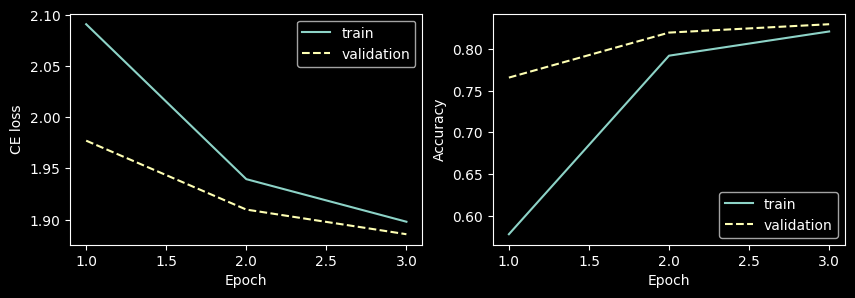

In [12]:
def plot_loss_curves(train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc):
    print(val_epochs_acc)
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    axs[0].plot(range(1, number_of_epochs + 1), np.array(train_epochs_losses), label='train')
    axs[0].plot(range(1, number_of_epochs + 1), np.array(val_epochs_losses), linestyle='dashed', label='validation')

    axs[1].plot(range(1, number_of_epochs + 1), train_epochs_acc, label='train')
    axs[1].plot(range(1, number_of_epochs + 1), val_epochs_acc, linestyle='dashed', label='validation')

    axs[0].set_ylabel(loss_func_name)
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()

    plt.show()
plot_loss_curves(*losses_data[1:, :].T)

In [13]:
def plot_difflayers(optical_setup):
    diff_layers = [layer for layer in optical_setup.net if isinstance(layer, sv.elements.DiffractiveLayer)]
    n_cols = len(diff_layers)
    n_rows = 1

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
    
    for ind_diff_layer, layer in enumerate(diff_layers):
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_diff_layer + 1}. DiffractiveLayer')
        im = ax_this.imshow(layer.mask.detach(), 'gist_stern')
        fig.colorbar()

plot_difflayers(optical_setup_loaded)

NameError: name 'optical_setup_loaded' is not defined

In [21]:
    k
print(
    'Results after training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_1):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_1 * 100):>0.1f} %'
)

validation: 100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.37it/s]

Results after training on TEST set:
	CE loss : 1.882397
	Accuracy : 83.9 %


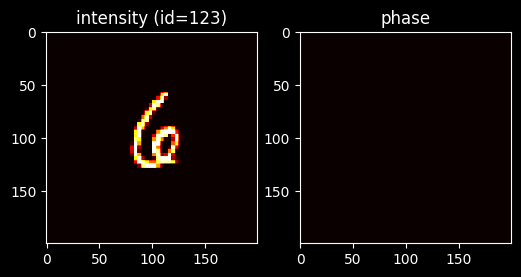

In [22]:
def plot_wavefront(test_wavefront, ind_test):
    cmap = 'hot'
    
    fig, axs = plt.subplots(1, 2, figsize=(2 * 3, 3))
    
    axs[0].set_title(f'intensity (id={ind_test})')
    axs[0].imshow(test_wavefront.intensity, cmap)
    
    axs[1].set_title(f'phase')
    axs[1].imshow(test_wavefront.phase, cmap)
# '1' - 3214, good
# '4' - 6152, good
# '6' - 123, good
# '8' - 128, good
# '0' - 3, good
ind_test = 123
test_wavefront = mnist_wf_test_ds[ind_test][0]
plot_wavefront(test_wavefront, ind_test)

In [1]:
# propagation of the example through the trained network
setup_scheme, test_wavefronts = optical_setup_loaded.stepwise_forward(test_wavefront)

NameError: name 'optical_setup_loaded' is not defined

NameError: name 'wavefront' is not defined

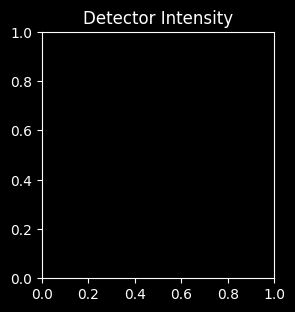

In [27]:
def plot_intensity(wavefront):
    fig, ax_this = plt.subplots(1, 1, figsize=(3, 3.2))
    ax_this.set_title('Detector Intensity')
    ax_this.imshow(wavefront.detach(), cmap='hot')
    
    for zone in get_zones_patches(detector_mask):
        ax_this.add_patch(zone)
#plot_intensity(test_wavefronts[-1])

fig, ax_this = plt.subplots(1, 1, figsize=(3, 3.2))
ax_this.set_title('Detector Intensity')
ax_this.imshow(wavefront.detach(), cmap='hot')

for zone in get_zones_patches(detector_mask):
    ax_this.add_patch(zone)

In [47]:
test_probas = detector_processor.forward(test_wavefronts[-1])
assert np.isclose(test_probas.sum().item(), 1)

for label, prob in enumerate(test_probas[0]):
    print(f'{label} : {prob * 100:.2f}%')

0 : 3.59%
1 : 3.18%
2 : 5.36%
3 : 2.53%
4 : 2.12%
5 : 2.65%
6 : 74.40%
7 : 1.28%
8 : 1.81%
9 : 3.09%


In [28]:
targets_test_lst = []
preds_test_lst = []  # lists of targets and model predictioons

# loop over the test dataset
for ind, (wavefront_this, target_this) in enumerate(tqdm(mnist_wf_test_ds)):
    optical_setup_loaded.net.eval()
    
    batch_wavefronts = torch.unsqueeze(wavefront_this, 0)
    batch_labels = torch.unsqueeze(torch.tensor(target_this), 0)  # to use forwards for batches
    
    with torch.no_grad():
        detector_output = optical_setup_loaded.net(batch_wavefronts)
        # process a detector image
        batch_probas = detector_processor.batch_forward(detector_output)

        for ind_in_batch in range(batch_labels.size()[0]):
            label_this = batch_labels[ind_in_batch].item()  # true label
            
            targets_test_lst.append(label_this)
            preds_test_lst.append(batch_probas[ind_in_batch].argmax().item())

100%|█████████████████████████████████████| 10000/10000 [04:10<00:00, 39.84it/s]


In [29]:
# ordinary confusion matrix
confusion_matrix = torch.zeros(
    size=(mat_y_size, mat_x_size),  # TODO: What is the size of the matrix?
    dtype=torch.int32
)

for ind in range(len(mnist_wf_test_ds)):
    confusion_matrix[targets_test_lst[ind], preds_test_lst[ind]] += 1

NameError: name 'mat_y_size' is not defined

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(6, 5))

# CONFUSION MATRIX
ax0.set_title('Confusion matrix')
ax0.matshow(confusion_matrix, cmap='Blues')

for i in range(NUMBER_OF_CLASSES):
    for j in range(NUMBER_OF_CLASSES):
        val = confusion_matrix[j, i].item()
        ax0.text(
            i, j, str(val),
            va='center', ha='center', 
            c='k', fontsize=9
        )

ax0.set_ylabel('Target')
ax0.set_xlabel('Predicted')

ax0.set_xticks(range(number_of_classes))
ax0.set_yticks(range(number_of_classes))

plt.show()

# save figure
# fig.savefig(f'{LOAD_FOLDER}/confusion_matrix.png', bbox_inches='tight')